<a href="https://colab.research.google.com/github/harishmohan83/text-util-service/blob/master/assignment4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [106]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns



In [4]:
!pip3 install bettermdptools

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 kB 8.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for bettermdptools: filename=bettermdptools-0.4.0-py3-none-any.whl size=11856 sha256=78aee65dfa210ad5420645418244d9e5576e5422f9662e3387d0dba5ff4c388a
  Stored in directory: /root/.cache/pip/wheels/b0/78/c1/a03ad20528780b5d6c33d3d8063f740b337388bf97b926f366
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827620 sha256=ae32b74f6a570991dd4cf0e1051eb4591ad8ab3887e22659afbdbe7eb420a465
  Stored in directory: /root/.cache/pip/wheels/b9/22/6d/3e7b32d98451b4cd9d12417052affbeeeea012955d437da1da
Successfully built bettermdptools gym
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2
ERROR: pip's dependency resolver do

In [136]:
from contextlib import closing
from io import StringIO
from os import path
from typing import List, Optional

import numpy as np

from gym import Env, logger, spaces, utils
from gym.envs.toy_text.utils import categorical_sample
from gym.error import DependencyNotInstalled

LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3

MAPS = {
    "4x4": ["SFFF", "FHFH", "FFFH", "HFFG"],
    "8x8": [
        "SFFFFFFF",
        "FFFFFFFF",
        "FFFHFFFF",
        "FFFFFHFF",
        "FFFHFFFF",
        "FHHFFFHF",
        "FHFFHFHF",
        "FFFHFFFG",
    ],
}


# DFS to check that it's a valid path.
def is_valid(board: List[List[str]], max_size: int) -> bool:
    frontier, discovered = [], set()
    frontier.append((0, 0))
    while frontier:
        r, c = frontier.pop()
        if not (r, c) in discovered:
            discovered.add((r, c))
            directions = [(1, 0), (0, 1), (-1, 0), (0, -1)]
            for x, y in directions:
                r_new = r + x
                c_new = c + y
                if r_new < 0 or r_new >= max_size or c_new < 0 or c_new >= max_size:
                    continue
                if board[r_new][c_new] == "G":
                    return True
                if board[r_new][c_new] != "H":
                    frontier.append((r_new, c_new))
    return False


def generate_random_map(size: int = 8, p: float = 0.8) -> List[str]:
    """Generates a random valid map (one that has a path from start to goal)

    Args:
        size: size of each side of the grid
        p: probability that a tile is frozen

    Returns:
        A random valid map
    """
    valid = False
    board = []  # initialize to make pyright happy

    while not valid:
        p = min(1, p)
        board = np.random.choice(["F", "H"], (size, size), p=[p, 1 - p])
        board[0][0] = "S"
        board[-1][-1] = "G"
        valid = is_valid(board, size)
    return ["".join(x) for x in board]


class FrozenLakeEnv(Env):
    """
    Frozen lake involves crossing a frozen lake from Start(S) to Goal(G) without falling into any Holes(H)
    by walking over the Frozen(F) lake.
    The agent may not always move in the intended direction due to the slippery nature of the frozen lake.


    ### Action Space
    The agent takes a 1-element vector for actions.
    The action space is `(dir)`, where `dir` decides direction to move in which can be:

    - 0: LEFT
    - 1: DOWN
    - 2: RIGHT
    - 3: UP

    ### Observation Space
    The observation is a value representing the agent's current position as
    current_row * nrows + current_col (where both the row and col start at 0).
    For example, the goal position in the 4x4 map can be calculated as follows: 3 * 4 + 3 = 15.
    The number of possible observations is dependent on the size of the map.
    For example, the 4x4 map has 16 possible observations.

    ### Rewards

    Reward schedule:
    - Reach goal(G): +1
    - Reach hole(H): 0
    - Reach frozen(F): 0

    ### Arguments

    ```
    gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True)
    ```

    `desc`: Used to specify custom map for frozen lake. For example,

        desc=["SFFF", "FHFH", "FFFH", "HFFG"].

        A random generated map can be specified by calling the function `generate_random_map`. For example,

        ```
        from gym.envs.toy_text.frozen_lake import generate_random_map

        gym.make('FrozenLake-v1', desc=generate_random_map(size=8))
        ```

    `map_name`: ID to use any of the preloaded maps.

        "4x4":[
            "SFFF",
            "FHFH",
            "FFFH",
            "HFFG"
            ]

        "8x8": [
            "SFFFFFFF",
            "FFFFFFFF",
            "FFFHFFFF",
            "FFFFFHFF",
            "FFFHFFFF",
            "FHHFFFHF",
            "FHFFHFHF",
            "FFFHFFFG",
        ]

    `is_slippery`: True/False. If True will move in intended direction with
    probability of 1/3 else will move in either perpendicular direction with
    equal probability of 1/3 in both directions.

        For example, if action is left and is_slippery is True, then:
        - P(move left)=1/3
        - P(move up)=1/3
        - P(move down)=1/3

    ### Version History
    * v1: Bug fixes to rewards
    * v0: Initial versions release (1.0.0)
    """

    metadata = {
        "render_modes": ["human", "ansi", "rgb_array"],
        "render_fps": 4,
    }

    def __init__(
        self,
        render_mode: Optional[str] = None,
        desc=None,
        map_name="4x4",
        is_slippery=True,
    ):
        if desc is None and map_name is None:
            desc = generate_random_map()
        elif desc is None:
            desc = MAPS[map_name]
        self.desc = desc = np.asarray(desc, dtype="c")
        self.nrow, self.ncol = nrow, ncol = desc.shape
        self.reward_range = (0, 1)

        nA = 4
        nS = nrow * ncol

        self.initial_state_distrib = np.array(desc == b"S").astype("float64").ravel()
        self.initial_state_distrib /= self.initial_state_distrib.sum()

        self.P = {s: {a: [] for a in range(nA)} for s in range(nS)}

        def to_s(row, col):
            return row * ncol + col

        def inc(row, col, a):
            if a == LEFT:
                col = max(col - 1, 0)
            elif a == DOWN:
                row = min(row + 1, nrow - 1)
            elif a == RIGHT:
                col = min(col + 1, ncol - 1)
            elif a == UP:
                row = max(row - 1, 0)
            return (row, col)

        def update_probability_matrix(row, col, action):
            newrow, newcol = inc(row, col, action)
            newstate = to_s(newrow, newcol)
            newletter = desc[newrow, newcol]
            terminated = bytes(newletter) in b"GH"
            # reward = float(newletter == b"G")
            if newletter == b"G":
                reward = 10.0
            elif newletter == b"H":
                reward = -0.01
            else:
                reward = -0.1
            return newstate, reward, terminated

        for row in range(nrow):
            for col in range(ncol):
                s = to_s(row, col)
                for a in range(4):
                    li = self.P[s][a]
                    letter = desc[row, col]
                    if letter in b"GH":
                        li.append((1.0, s, 0, True))
                    else:
                        if is_slippery:
                            for b in [(a - 1) % 4, a, (a + 1) % 4]:
                                li.append(
                                    (1.0 / 3.0, *update_probability_matrix(row, col, b))
                                )
                        else:
                            li.append((1.0, *update_probability_matrix(row, col, a)))

        self.observation_space = spaces.Discrete(nS)
        self.action_space = spaces.Discrete(nA)

        self.render_mode = render_mode

        # pygame utils
        self.window_size = (min(64 * ncol, 512), min(64 * nrow, 512))
        self.cell_size = (
            self.window_size[0] // self.ncol,
            self.window_size[1] // self.nrow,
        )
        self.window_surface = None
        self.clock = None
        self.hole_img = None
        self.cracked_hole_img = None
        self.ice_img = None
        self.elf_images = None
        self.goal_img = None
        self.start_img = None

    def step(self, a):
        transitions = self.P[self.s][a]
        i = categorical_sample([t[0] for t in transitions], self.np_random)
        p, s, r, t = transitions[i]
        self.s = s
        self.lastaction = a

        if self.render_mode == "human":
            self.render()
        return (int(s), r, t, False, {"prob": p})

    def reset(
        self,
        *,
        seed: Optional[int] = None,
        options: Optional[dict] = None,
    ):
        super().reset(seed=seed)
        self.s = categorical_sample(self.initial_state_distrib, self.np_random)
        self.lastaction = None

        if self.render_mode == "human":
            self.render()
        return int(self.s), {"prob": 1}

    def render(self):
        if self.render_mode is None:
            logger.warn(
                "You are calling render method without specifying any render mode. "
                "You can specify the render_mode at initialization, "
                f'e.g. gym("{self.spec.id}", render_mode="rgb_array")'
            )
        elif self.render_mode == "ansi":
            return self._render_text()
        else:  # self.render_mode in {"human", "rgb_array"}:
            return self._render_gui(self.render_mode)

    def _render_gui(self, mode):
        try:
            import pygame
        except ImportError:
            raise DependencyNotInstalled(
                "pygame is not installed, run `pip install gym[toy_text]`"
            )

        if self.window_surface is None:
            pygame.init()

            if mode == "human":
                pygame.display.init()
                pygame.display.set_caption("Frozen Lake")
                self.window_surface = pygame.display.set_mode(self.window_size)
            elif mode == "rgb_array":
                self.window_surface = pygame.Surface(self.window_size)

        assert (
            self.window_surface is not None
        ), "Something went wrong with pygame. This should never happen."

        if self.clock is None:
            self.clock = pygame.time.Clock()
        if self.hole_img is None:
            file_name = path.join(path.dirname(__file__), "img/hole.png")
            self.hole_img = pygame.transform.scale(
                pygame.image.load(file_name), self.cell_size
            )
        if self.cracked_hole_img is None:
            file_name = path.join(path.dirname(__file__), "img/cracked_hole.png")
            self.cracked_hole_img = pygame.transform.scale(
                pygame.image.load(file_name), self.cell_size
            )
        if self.ice_img is None:
            file_name = path.join(path.dirname(__file__), "img/ice.png")
            self.ice_img = pygame.transform.scale(
                pygame.image.load(file_name), self.cell_size
            )
        if self.goal_img is None:
            file_name = path.join(path.dirname(__file__), "img/goal.png")
            self.goal_img = pygame.transform.scale(
                pygame.image.load(file_name), self.cell_size
            )
        if self.start_img is None:
            file_name = path.join(path.dirname(__file__), "img/stool.png")
            self.start_img = pygame.transform.scale(
                pygame.image.load(file_name), self.cell_size
            )
        if self.elf_images is None:
            elfs = [
                path.join(path.dirname(__file__), "img/elf_left.png"),
                path.join(path.dirname(__file__), "img/elf_down.png"),
                path.join(path.dirname(__file__), "img/elf_right.png"),
                path.join(path.dirname(__file__), "img/elf_up.png"),
            ]
            self.elf_images = [
                pygame.transform.scale(pygame.image.load(f_name), self.cell_size)
                for f_name in elfs
            ]

        desc = self.desc.tolist()
        assert isinstance(desc, list), f"desc should be a list or an array, got {desc}"
        for y in range(self.nrow):
            for x in range(self.ncol):
                pos = (x * self.cell_size[0], y * self.cell_size[1])
                rect = (*pos, *self.cell_size)

                self.window_surface.blit(self.ice_img, pos)
                if desc[y][x] == b"H":
                    self.window_surface.blit(self.hole_img, pos)
                elif desc[y][x] == b"G":
                    self.window_surface.blit(self.goal_img, pos)
                elif desc[y][x] == b"S":
                    self.window_surface.blit(self.start_img, pos)

                pygame.draw.rect(self.window_surface, (180, 200, 230), rect, 1)

        # paint the elf
        bot_row, bot_col = self.s // self.ncol, self.s % self.ncol
        cell_rect = (bot_col * self.cell_size[0], bot_row * self.cell_size[1])
        last_action = self.lastaction if self.lastaction is not None else 1
        elf_img = self.elf_images[last_action]

        if desc[bot_row][bot_col] == b"H":
            self.window_surface.blit(self.cracked_hole_img, cell_rect)
        else:
            self.window_surface.blit(elf_img, cell_rect)

        if mode == "human":
            pygame.event.pump()
            pygame.display.update()
            self.clock.tick(self.metadata["render_fps"])
        elif mode == "rgb_array":
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(self.window_surface)), axes=(1, 0, 2)
            )

    @staticmethod
    def _center_small_rect(big_rect, small_dims):
        offset_w = (big_rect[2] - small_dims[0]) / 2
        offset_h = (big_rect[3] - small_dims[1]) / 2
        return (
            big_rect[0] + offset_w,
            big_rect[1] + offset_h,
        )

    def _render_text(self):
        desc = self.desc.tolist()
        outfile = StringIO()

        row, col = self.s // self.ncol, self.s % self.ncol
        desc = [[c.decode("utf-8") for c in line] for line in desc]
        desc[row][col] = utils.colorize(desc[row][col], "red", highlight=True)
        if self.lastaction is not None:
            outfile.write(f"  ({['Left', 'Down', 'Right', 'Up'][self.lastaction]})\n")
        else:
            outfile.write("\n")
        outfile.write("\n".join("".join(line) for line in desc) + "\n")

        with closing(outfile):
            return outfile.getvalue()

    def close(self):
        if self.window_surface is not None:
            import pygame

            pygame.display.quit()
            pygame.quit()


# Elf and stool from https://franuka.itch.io/rpg-snow-tileset
# All other assets by Mel Tillery http://www.cyaneus.com/

In [108]:
import gym
import pygame
from algorithms.rl import RL
from examples.test_env import TestEnv
from algorithms.planner import Planner
from examples.plots import Plots
from examples.grid_search import GridSearch
import math
from gym.envs.toy_text.frozen_lake import generate_random_map
import warnings
from matplotlib.colors import LinearSegmentedColormap

In [243]:
class Plots_Custom:
    @staticmethod
    def grid_world_policy_plot(data, label, size):
        if not math.modf(math.sqrt(len(data)))[0] == 0.0:
            warnings.warn("Grid map expected.  Check data length")
        else:
            data = np.around(np.array(data).reshape((size, size)), 2)
            df = pd.DataFrame(data=data)
            my_colors = ((0.0, 0.0, 0.0, 1.0), (0.8, 0.0, 0.0, 1.0), (0.0, 0.8, 0.0, 1.0), (0.0, 0.0, 0.8, 1.0))
            cmap = LinearSegmentedColormap.from_list('Custom', my_colors, len(my_colors))
            ax = sns.heatmap(df, cmap=cmap, linewidths=1.0)
            colorbar = ax.collections[0].colorbar
            # colorbar.set_ticks([0.4, 1.25, 1.5, 2.5])
            colorbar.set_ticks(np.linspace(data.min(), data.max(), num=4))
            colorbar.set_ticklabels(['Left', 'Down', 'Right', 'Up'])
            plt.title(label)
            plt.show()

    @staticmethod
    def grid_values_heat_map(data, label, size):
        plt.figure(figsize=(15, 15))
        if not math.modf(math.sqrt(len(data)))[0] == 0.0:
            warnings.warn("Grid map expected.  Check data length")
        else:
            data = np.around(np.array(data).reshape((size, size)), 2)
            df = pd.DataFrame(data=data)
            sns.heatmap(df, annot=True).set_title(label)
            plt.figure(figsize=(50, 50))
            plt.show()

    @staticmethod
    def v_iters_plot(data, label):
        df = pd.DataFrame(data=data)
        df.columns = [label]
        sns.set_theme(style="whitegrid")
        title = label + " v Iterations"
        sns.lineplot(x=df.index, y=label, data=df).set_title(title)
        plt.show()

In [163]:
def plot_directions_map(states, actions, map_size, env, title):
    """Plot the last frame of the simulation and the policy learned."""
    # qtable_val_max, qtable_directions = qtable_directions_map(qtable, map_size)

    # Plot the last frame
    # env.reset()
    # plt.imshow(env.render())
    # plt.axis("off")
    # plt.title("Last frame")
    # plt.show()

    # Plot the policy
    # print(states.shape)
    # print(actions.shape)

    states_val_max = states.reshape(map_size, map_size)

    directions = {0: "←", 1: "↓", 2: "→", 3: "↑"}
    action_directions = np.empty(actions.flatten().shape, dtype=str)
    eps = np.finfo(float).eps  # Minimum float number on the machine
    for idx, val in enumerate(actions.flatten()):
        if states.flatten()[idx] > eps:
            # Assign an arrow only if a minimal Q-value has been learned as best action
            # otherwise since 0 is a direction, it also gets mapped on the tiles where
            # it didn't actually learn anything
            action_directions[idx] = directions[val]
    action_directions = action_directions.reshape(map_size, map_size)


    sns.heatmap(
        states_val_max,
        annot=action_directions,
        fmt="",
        # ax=ax[1],
        cmap=sns.color_palette("Blues", as_cmap=True),
        linewidths=0.7,
        linecolor="black",
        xticklabels=[],
        yticklabels=[],
        annot_kws={"fontsize": "xx-large"},
    ).set(title=title)
    # for _, spine in ax[1].spines.items():
    #     spine.set_visible(True)
    #     spine.set_linewidth(0.7)
    #     spine.set_color("black")
    plt.show()



/usr/local/lib/python3.10/dist-packages/algorithms/planner.py:76: UserWarning: Max iterations reached before convergence.  Check theta and n_iters.  
  warnings.warn("Max iterations reached before convergence.  Check theta and n_iters.  ")


runtime = 2.06 seconds


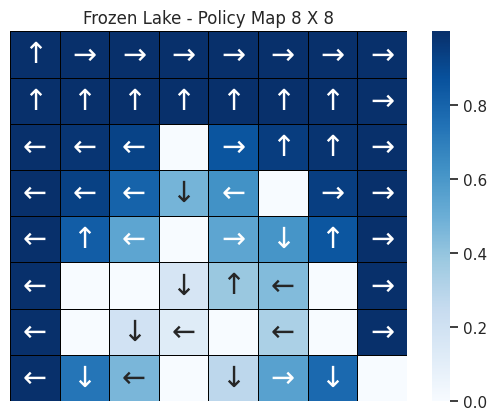

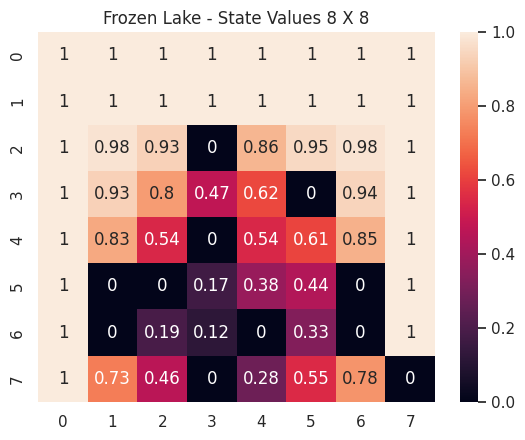

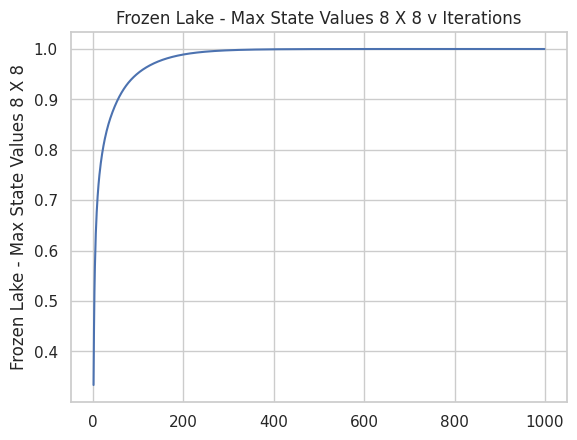

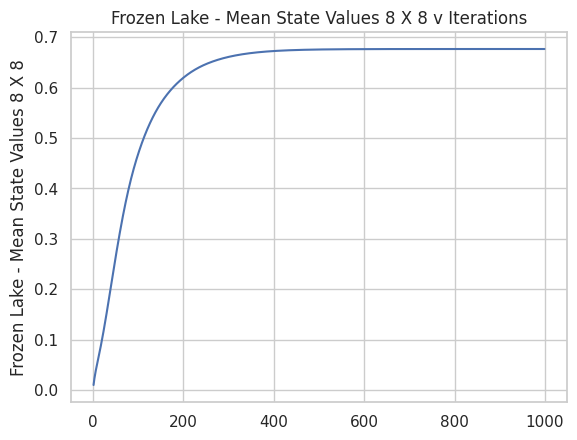

In [183]:
frozen_lake = gym.make('FrozenLake8x8-v1', render_mode="rgb_array")

size=8
# frozen_lake = FrozenLakeEnv(desc=generate_random_map(size), render_mode="rgb_array", is_slippery=True)

V, V_track, pi = Planner(frozen_lake.P).value_iteration(n_iters=1000, gamma=1, theta=1e-10)
n_states = frozen_lake.observation_space.n
new_pi = list(map(lambda x: pi(x), range(n_states)))
s = int(math.sqrt(n_states))
# Plots.grid_world_policy_plot(np.array(new_pi), "Grid World Policy")
plot_directions_map(np.array(V), np.array(new_pi), size, frozen_lake, "Frozen Lake - Policy Map 8 X 8")
Plots.grid_values_heat_map(V, "Frozen Lake - State Values 8 X 8")


max_value_per_iter = np.amax(V_track, axis=1)
max_value_per_iter[max_value_per_iter == 0.0] = np.nan
Plots.v_iters_plot(max_value_per_iter, "Frozen Lake - Max State Values 8 X 8")
mean_value_per_iter = np.mean(V_track, axis=1)
mean_value_per_iter[mean_value_per_iter == 0.0] = np.nan
Plots.v_iters_plot(mean_value_per_iter, "Frozen Lake - Mean State Values 8 X 8")


/usr/local/lib/python3.10/dist-packages/algorithms/planner.py:76: UserWarning: Max iterations reached before convergence.  Check theta and n_iters.  
  warnings.warn("Max iterations reached before convergence.  Check theta and n_iters.  ")


runtime = 6.02 seconds


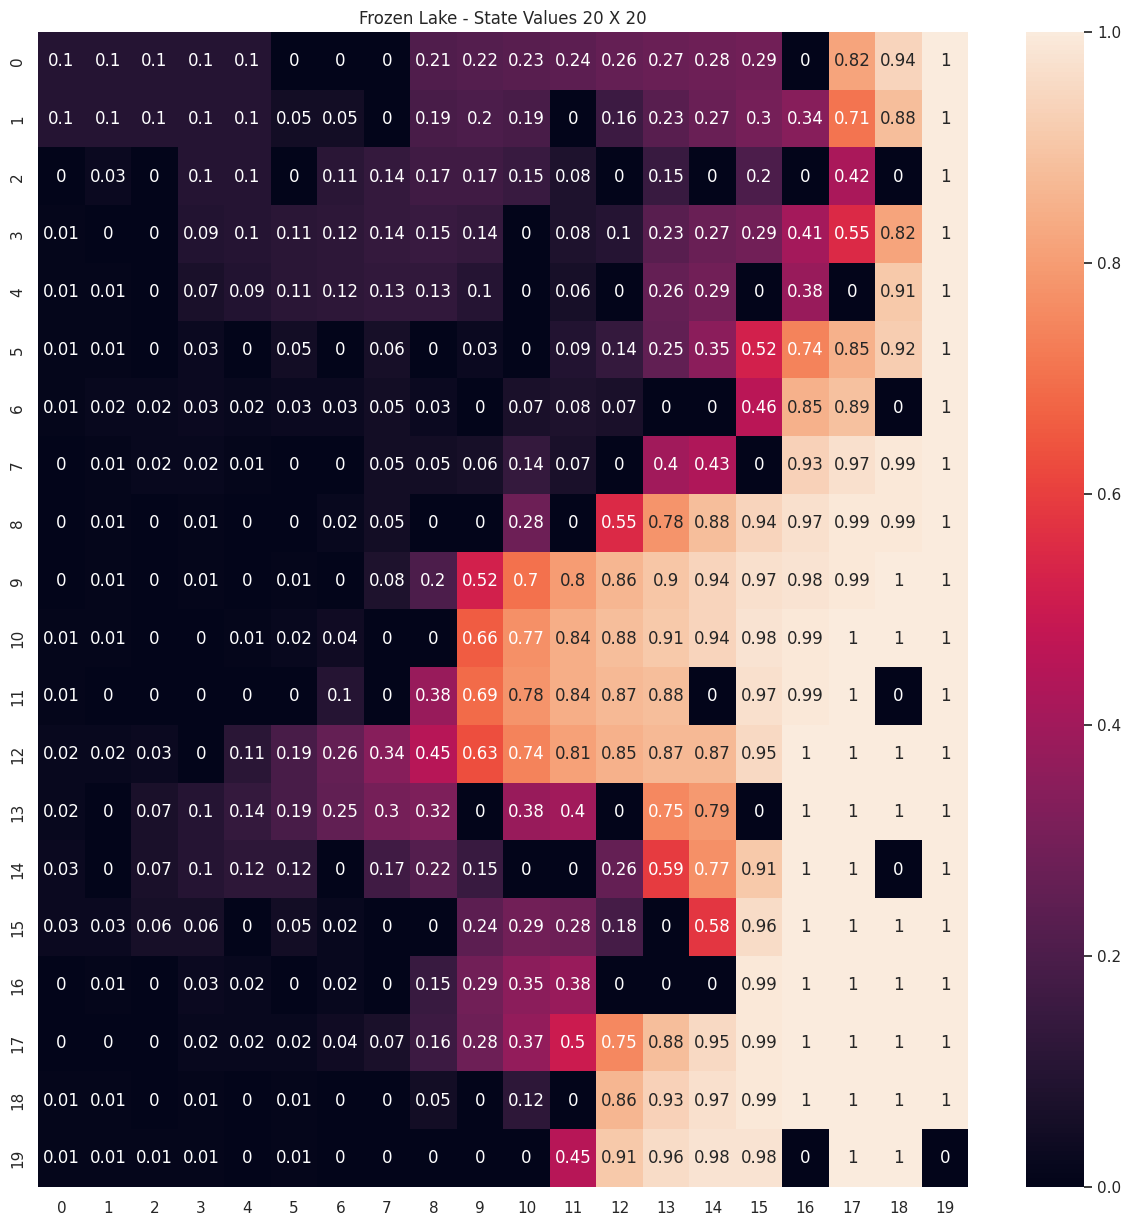

<Figure size 5000x5000 with 0 Axes>

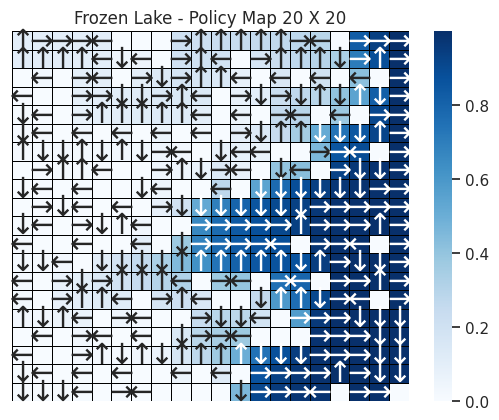

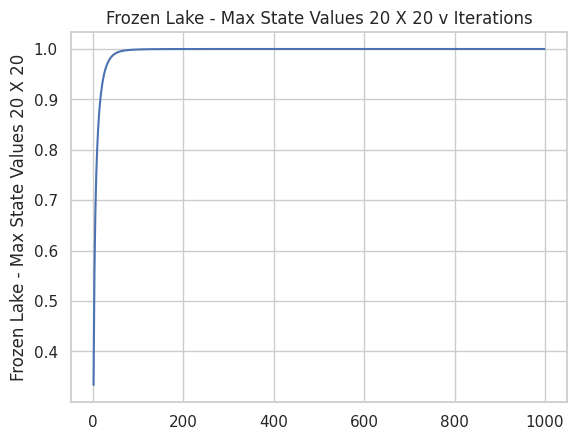

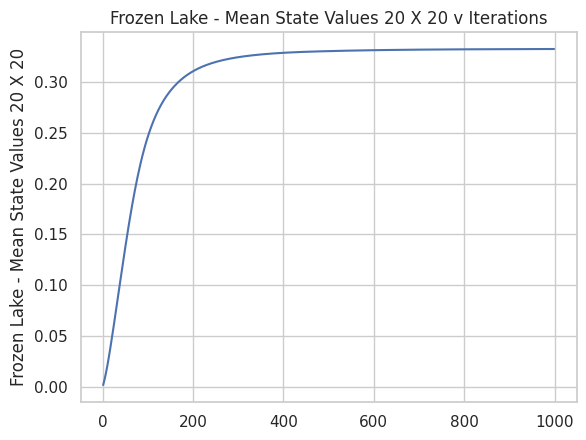

In [244]:
size=20
frozen_lake = gym.make('FrozenLake-v1', desc=generate_random_map(size), render_mode=None)
# frozen_lake = FrozenLakeEnv(desc=generate_random_map(size), render_mode=None)

V, V_track, pi = Planner(frozen_lake.env.P).value_iteration(n_iters=1000, gamma=1, theta=1e-10)
n_states = frozen_lake.observation_space.n
new_pi = list(map(lambda x: pi(x), range(n_states)))
s = int(math.sqrt(n_states))
# Plots_Custom.grid_world_policy_plot(np.array(new_pi), "Grid World Policy", size)
Plots_Custom.grid_values_heat_map(V, "Frozen Lake - State Values 20 X 20", size)
plot_directions_map(np.array(V), np.array(new_pi), size, frozen_lake.env, "Frozen Lake - Policy Map 20 X 20")
max_value_per_iter = np.amax(V_track, axis=1)
max_value_per_iter[max_value_per_iter == 0.0] = np.nan
Plots_Custom.v_iters_plot(max_value_per_iter, "Frozen Lake - Max State Values 20 X 20")
mean_value_per_iter = np.mean(V_track, axis=1)
mean_value_per_iter[mean_value_per_iter == 0.0] = np.nan
Plots_Custom.v_iters_plot(mean_value_per_iter, "Frozen Lake - Mean State Values 20 X 20")


In [ ]:
!git clone https://github.com/jlm429/bettermdptools
!mv /content/bettermdptools/examples/blackjack-envP /usr/local/lib/python3.10/dist-packages/examples

In [216]:
import os
import warnings

import gym
import pygame
import pickle

class BlackjackCustom:
    def __init__(self, render_mode=None):
        self._env = gym.make('Blackjack-v1', render_mode=render_mode)
        # Explanation of convert_state_obs lambda:
        # def function(state, done):
        # 	if done:
		#         return -1
        #     else:
        #         if state[2]:
        #             int(f"{state[0]+6}{(state[1]-2)%10}")
        #         else:
        #             int(f"{state[0]-4}{(state[1]-2)%10}")
        self._convert_state_obs = lambda state, done: (
            -1 if done else int(f"{state[0] + 6}{(state[1] - 2) % 10}") if state[2] else int(
                f"{state[0] - 4}{(state[1] - 2) % 10}"))
        # Transitions and rewards matrix from: https://github.com/rhalbersma/gym-blackjack-v1
        # current_dir = os.path.dirname(os.path.realpath('__file__'))
        current_dir = "/usr/local/lib/python3.10/dist-packages/examples"
        file_name = 'blackjack-envP'
        f = os.path.join(current_dir, file_name)
        try:
            self._P = pickle.load(open(f, "rb"))
        except IOError:
            print("Pickle load failed.  Check path", f)
        self._n_actions = self.env.action_space.n
        self._n_states = len(self._P)

    @property
    def n_actions(self):
        return self._n_actions

    @n_actions.setter
    def n_actions(self, n_actions):
        self._n_actions = n_actions

    @property
    def n_states(self):
        return self._n_states

    @n_states.setter
    def n_states(self, n_states):
        self._n_states = n_states

    @property
    def P(self):
        return self._P

    @P.setter
    def P(self, P):
        self._P = P

    @property
    def env(self):
        return self._env

    @env.setter
    def env(self, env):
        self._env = env

    @property
    def convert_state_obs(self):
        return self._convert_state_obs

    @convert_state_obs.setter
    def convert_state_obs(self, convert_state_obs):
        self._convert_state_obs = convert_state_obs

In [253]:
def plot_bj_map(states, actions, title):

    states_val_max = states.reshape(29, 10)

    directions = {0: "S", 1: "H"}
    action_directions = np.empty(actions.flatten().shape, dtype=str)
    eps = np.finfo(float).eps  # Minimum float number on the machine
    for idx, val in enumerate(actions.flatten()):
        # if states.flatten()[idx] > eps:
        action_directions[idx] = directions[val]
    action_directions = action_directions.reshape(29, 10)

    # print(action_directions)

    plt.figure(figsize=(12, 9))
    sns.heatmap(
        states_val_max,
        annot=action_directions,
        fmt="",
        # ax=ax[1],
        cmap=sns.color_palette("Blues", as_cmap=True),
        # linewidths=0.7,
        linecolor="black",
        xticklabels=[],
        yticklabels=[],
        # annot_kws={"fontsize": "xx-large"},
    ).set(title=title)

    plt.show()

def bj_heat_map(data, label):
  plt.figure(figsize=(12, 9))
  data = np.around(np.array(data).reshape((29, 10)), 2)
  df = pd.DataFrame(data=data)
  sns.heatmap(df, annot=True).set_title(label)
  plt.show()

def bj_v_iters_plot(data, label):
  df = pd.DataFrame(data=data)
  df.columns = [label]
  sns.set_theme(style="whitegrid")
  title = label + " v Iterations"
  sns.lineplot(x=df.index, y=label, data=df).set_title(title)
  plt.show()



runtime = 0.05 seconds


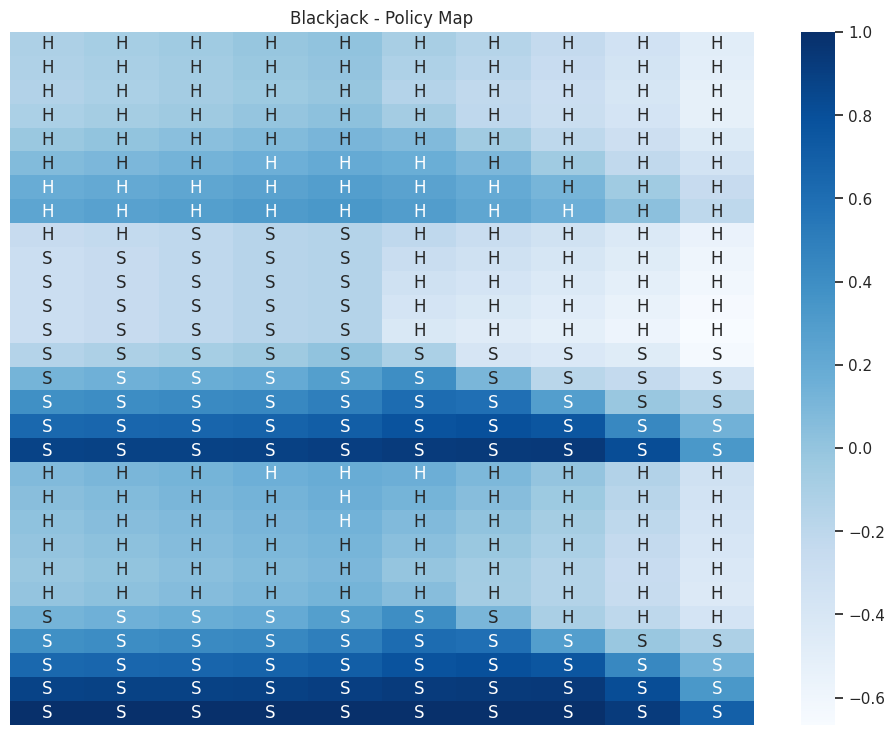

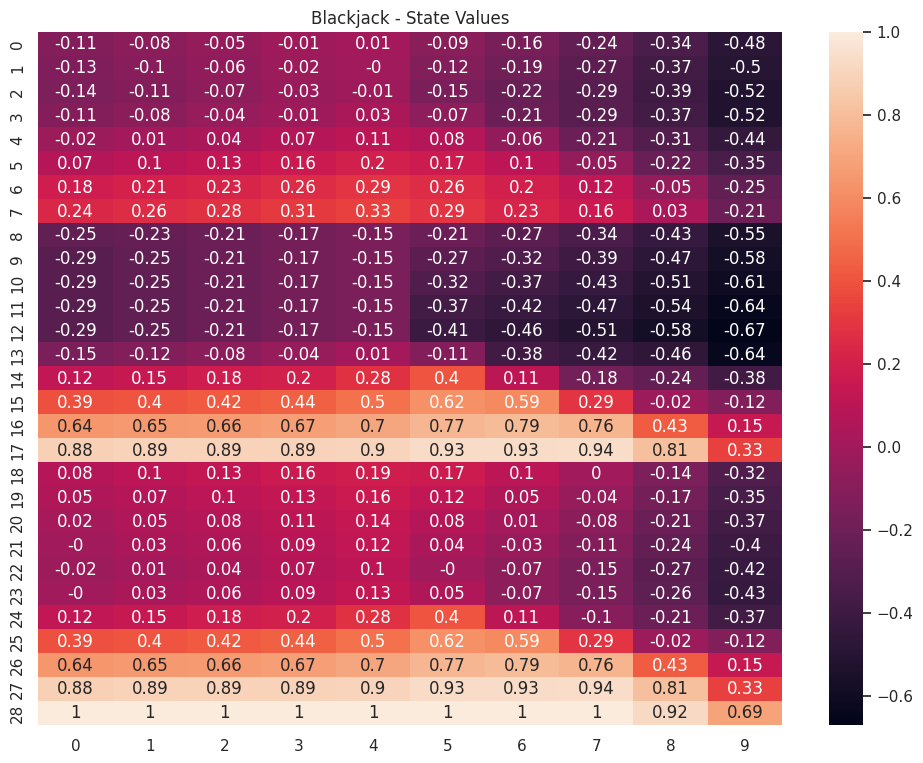

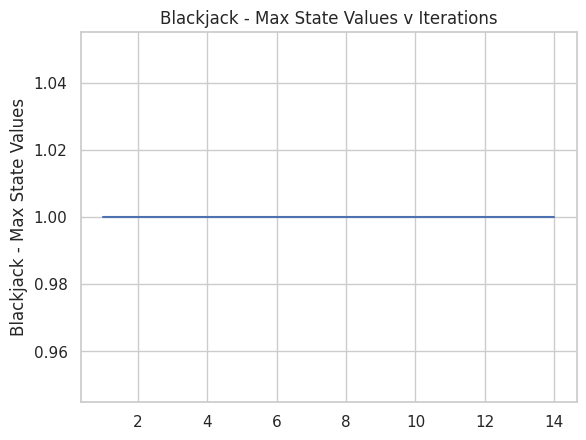

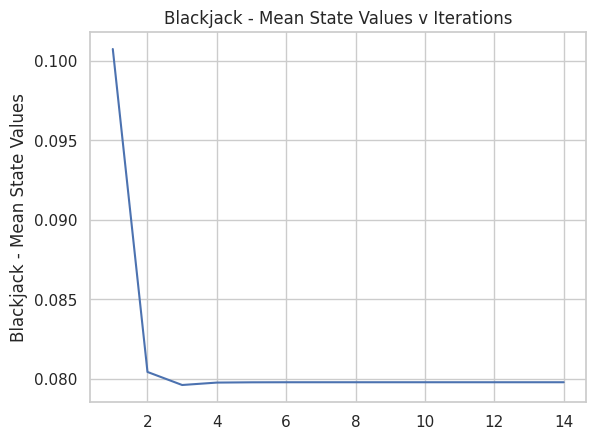

In [258]:
from examples.blackjack import Blackjack
blackjack = BlackjackCustom()

V, V_track, pi = Planner(blackjack.P).value_iteration(n_iters=20, gamma=1, theta=1e-20)
n_states = blackjack.n_states

new_pi = list(map(lambda x: pi(x), range(n_states)))


# s = int(math.sqrt(n_states))
# new_pi = np.array(new_pi)

# new_pi_size = math.pow(s, 2)
# new_pi = new_pi[0: int(new_pi_size)]

plot_bj_map(np.array(V), np.array(new_pi), "Blackjack - Policy Map")


bj_heat_map(V, "Blackjack - State Values")


max_value_per_iter = np.amax(V_track, axis=1)
max_value_per_iter[max_value_per_iter == 0.0] = np.nan
bj_v_iters_plot(max_value_per_iter, "Blackjack - Max State Values")
mean_value_per_iter = np.mean(V_track, axis=1)
mean_value_per_iter[mean_value_per_iter == 0.0] = np.nan
bj_v_iters_plot(mean_value_per_iter, "Blackjack - Mean State Values")

# blackjack._env.reset()
# blackjack._env.render()




runtime = 5.88 seconds


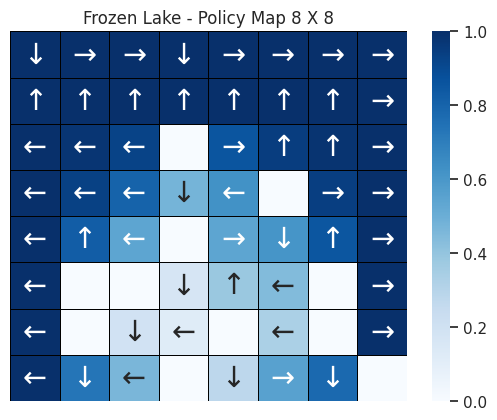

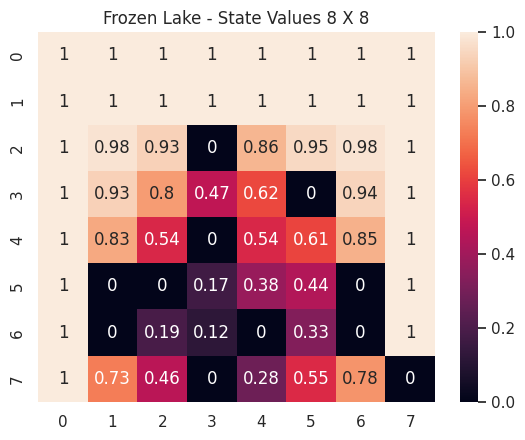

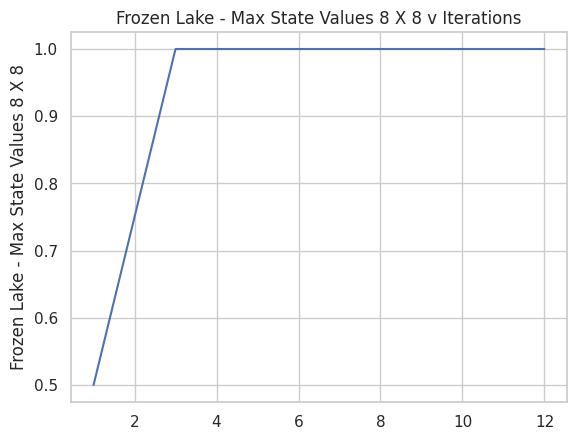

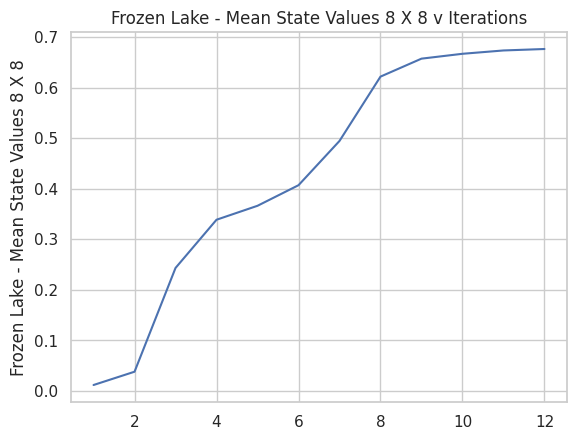

In [261]:
frozen_lake = gym.make('FrozenLake8x8-v1', render_mode="rgb_array")

size=8
# frozen_lake = FrozenLakeEnv(desc=generate_random_map(size), render_mode="rgb_array", is_slippery=True)

V, V_track, pi = Planner(frozen_lake.P).policy_iteration(n_iters=100, gamma=1, theta=1e-10)
n_states = frozen_lake.observation_space.n
new_pi = list(map(lambda x: pi(x), range(n_states)))
s = int(math.sqrt(n_states))
# Plots.grid_world_policy_plot(np.array(new_pi), "Grid World Policy")
plot_directions_map(np.array(V), np.array(new_pi), size, frozen_lake, "Frozen Lake - Policy Map 8 X 8")
Plots.grid_values_heat_map(V, "Frozen Lake - State Values 8 X 8")


max_value_per_iter = np.amax(V_track, axis=1)
max_value_per_iter[max_value_per_iter == 0.0] = np.nan
Plots.v_iters_plot(max_value_per_iter, "Frozen Lake - Max State Values 8 X 8")
mean_value_per_iter = np.mean(V_track, axis=1)
mean_value_per_iter[mean_value_per_iter == 0.0] = np.nan
Plots.v_iters_plot(mean_value_per_iter, "Frozen Lake - Mean State Values 8 X 8")


runtime = 1725.00 seconds


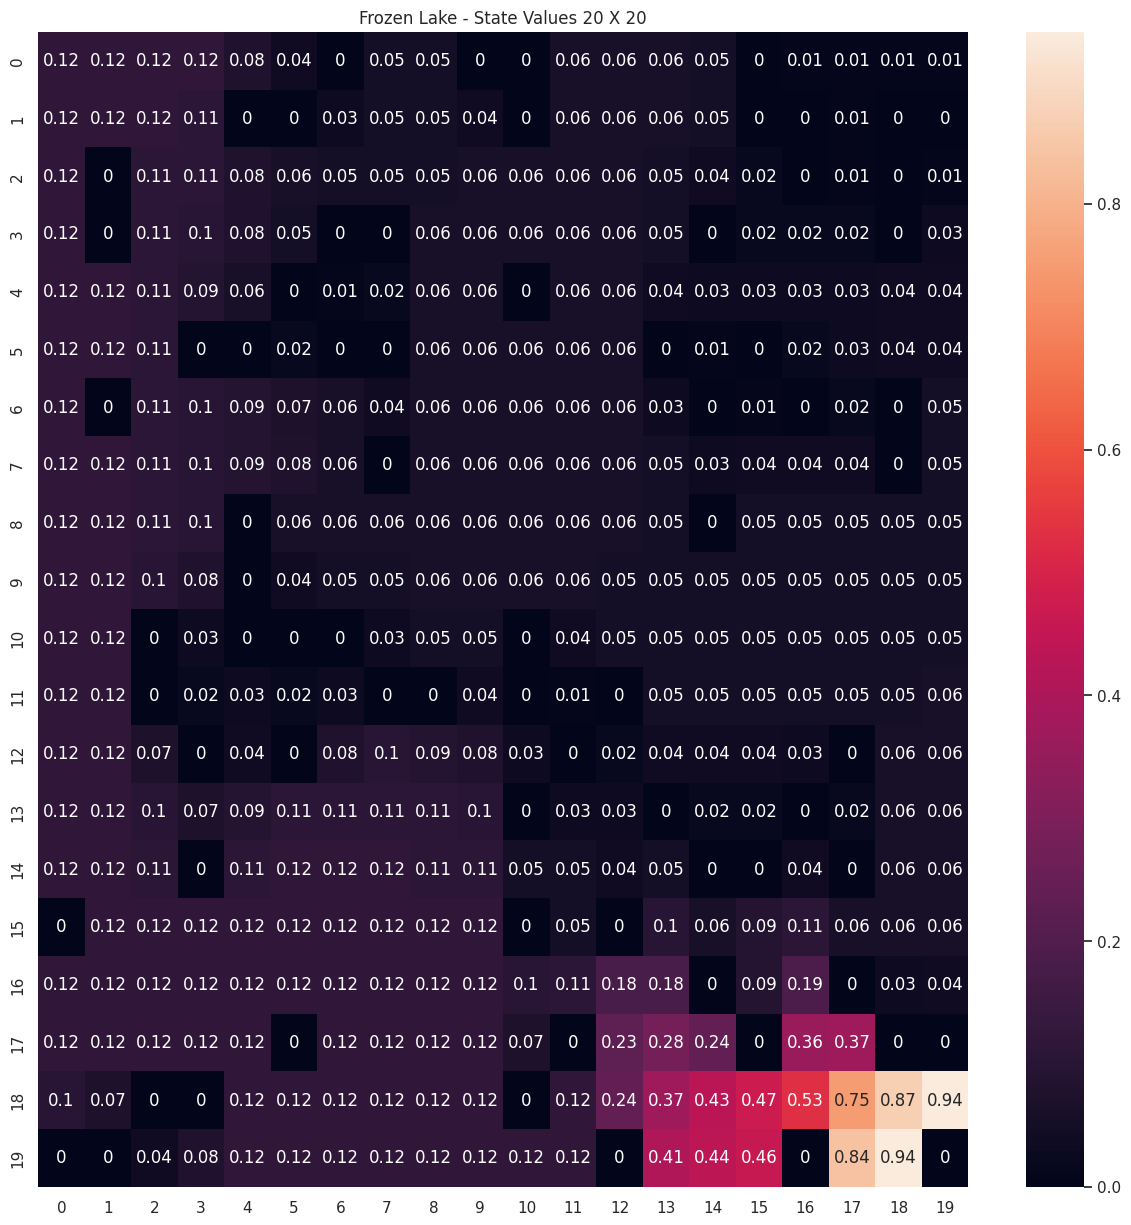

<Figure size 5000x5000 with 0 Axes>

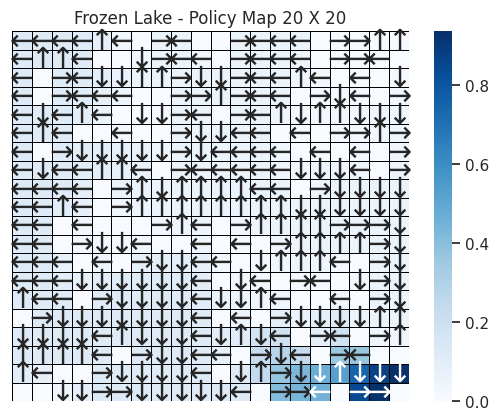

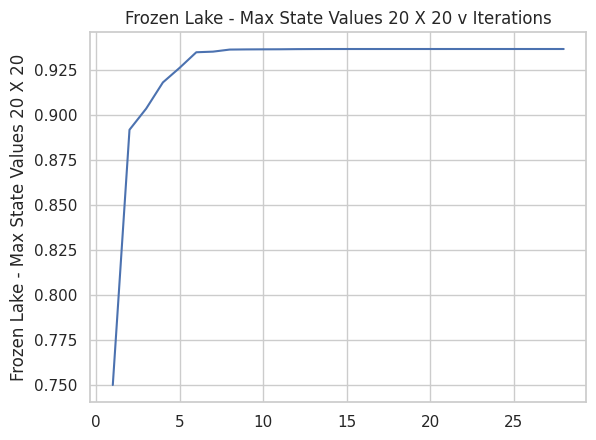

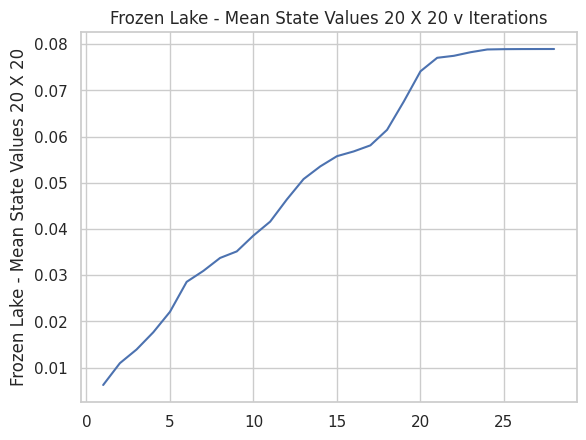

In [262]:
size=20
frozen_lake = gym.make('FrozenLake-v1', desc=generate_random_map(size), render_mode=None)
# frozen_lake = FrozenLakeEnv(desc=generate_random_map(size), render_mode=None)

V, V_track, pi = Planner(frozen_lake.env.P).policy_iteration(n_iters=100, gamma=1, theta=1e-10)
n_states = frozen_lake.observation_space.n
new_pi = list(map(lambda x: pi(x), range(n_states)))
s = int(math.sqrt(n_states))
# Plots_Custom.grid_world_policy_plot(np.array(new_pi), "Grid World Policy", size)
Plots_Custom.grid_values_heat_map(V, "Frozen Lake - State Values 20 X 20", size)
plot_directions_map(np.array(V), np.array(new_pi), size, frozen_lake.env, "Frozen Lake - Policy Map 20 X 20")
max_value_per_iter = np.amax(V_track, axis=1)
max_value_per_iter[max_value_per_iter == 0.0] = np.nan
Plots_Custom.v_iters_plot(max_value_per_iter, "Frozen Lake - Max State Values 20 X 20")
mean_value_per_iter = np.mean(V_track, axis=1)
mean_value_per_iter[mean_value_per_iter == 0.0] = np.nan
Plots_Custom.v_iters_plot(mean_value_per_iter, "Frozen Lake - Mean State Values 20 X 20")

runtime = 3.17 seconds


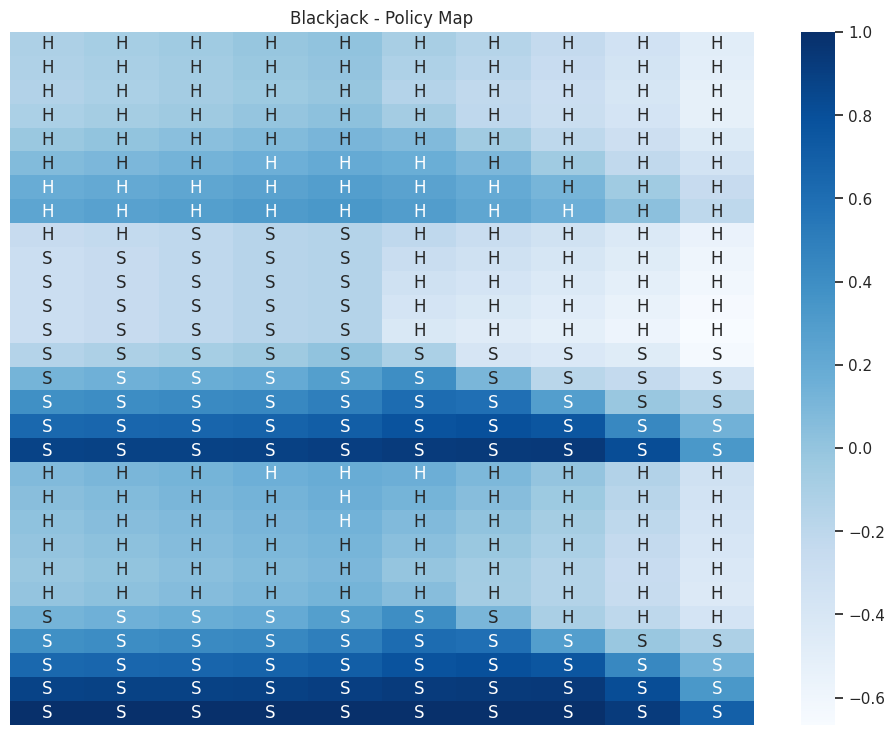

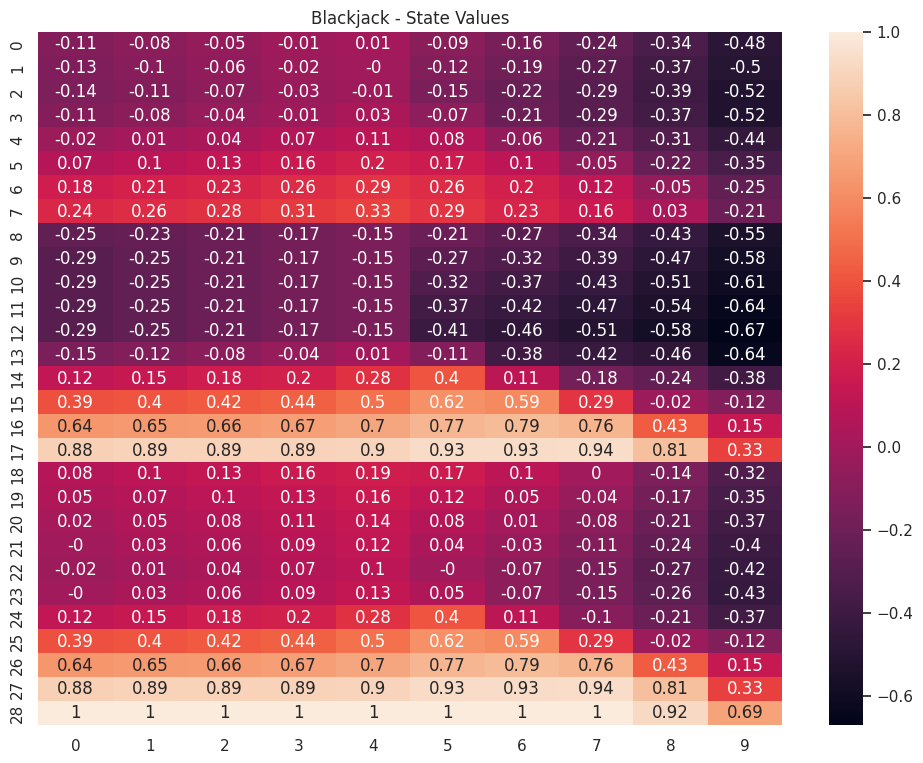

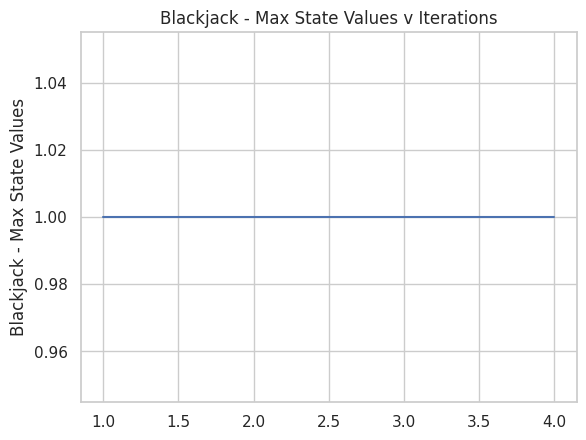

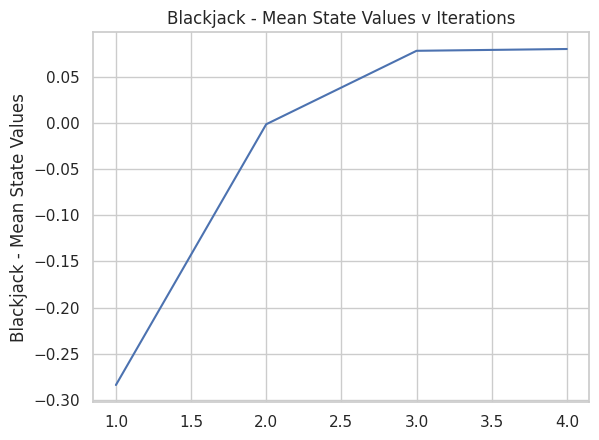

In [264]:
from examples.blackjack import Blackjack
blackjack = BlackjackCustom()

V, V_track, pi = Planner(blackjack.P).policy_iteration(n_iters=100, gamma=1, theta=1e-10)
n_states = blackjack.n_states

new_pi = list(map(lambda x: pi(x), range(n_states)))


# s = int(math.sqrt(n_states))
# new_pi = np.array(new_pi)

# new_pi_size = math.pow(s, 2)
# new_pi = new_pi[0: int(new_pi_size)]

plot_bj_map(np.array(V), np.array(new_pi), "Blackjack - Policy Map")


bj_heat_map(V, "Blackjack - State Values")


max_value_per_iter = np.amax(V_track, axis=1)
max_value_per_iter[max_value_per_iter == 0.0] = np.nan
bj_v_iters_plot(max_value_per_iter, "Blackjack - Max State Values")
mean_value_per_iter = np.mean(V_track, axis=1)
mean_value_per_iter[mean_value_per_iter == 0.0] = np.nan
bj_v_iters_plot(mean_value_per_iter, "Blackjack - Mean State Values")

In [272]:
frozen_lake = gym.make('FrozenLake8x8-v1', max_episode_steps=50000, render_mode=None)
size=8

Q, V, pi, Q_track, pi_track = RL(frozen_lake.env).q_learning(epsilon_decay_ratio=0.9, init_epsilon=1, alpha_decay_ratio=0.1, gamma=1, n_episodes= 30000)

runtime = 82.07 seconds


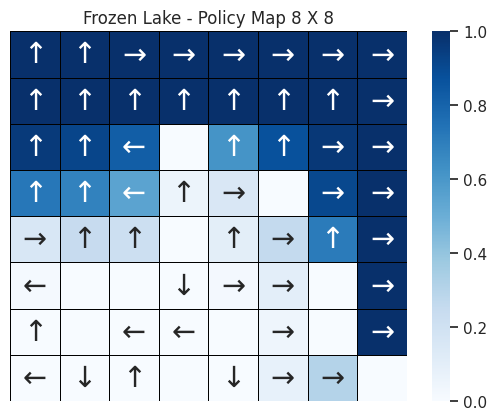

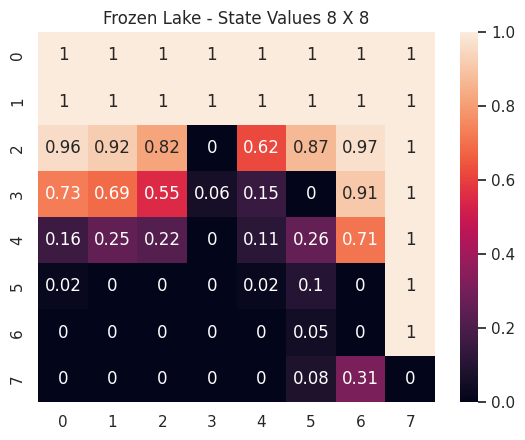

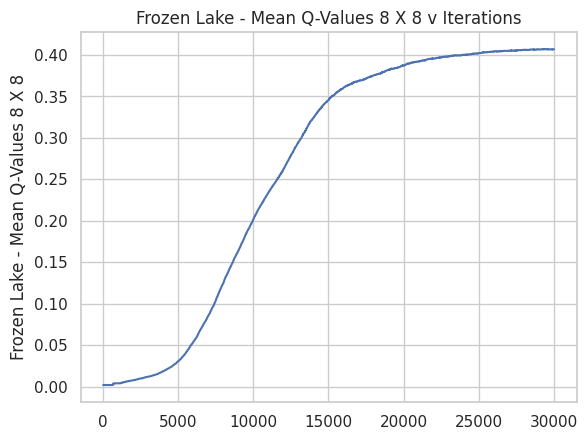

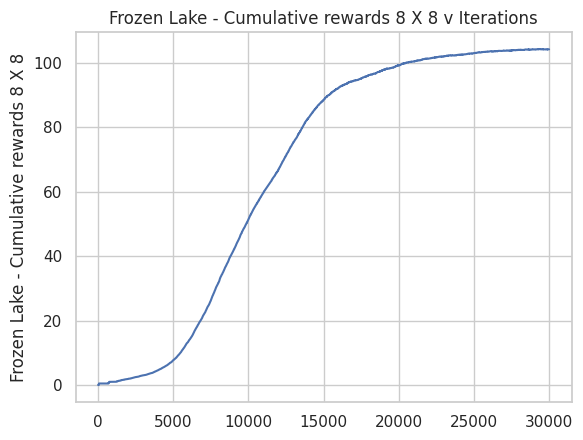

In [273]:
n_states = frozen_lake.observation_space.n
new_pi = list(map(lambda x: pi(x), range(n_states)))
s = int(math.sqrt(n_states))
# Plots.grid_world_policy_plot(np.array(new_pi), "Grid World Policy")
plot_directions_map(np.array(V), np.array(new_pi), size, frozen_lake, "Frozen Lake - Policy Map 8 X 8")
Plots.grid_values_heat_map(V, "Frozen Lake - State Values 8 X 8")

mean_value_per_iter = np.mean(np.mean(Q_track, axis=2), axis=1)
mean_value_per_iter[mean_value_per_iter == 0.0] = np.nan
Plots.v_iters_plot(mean_value_per_iter, "Frozen Lake - Mean Q-Values 8 X 8")

cumulative_rewards_per_iter = np.sum(np.sum(Q_track, axis=2), axis=1)
# cumulative_rewards_per_iter[cumulative_rewards_per_iter == 0.0] = np.nan
Plots.v_iters_plot(cumulative_rewards_per_iter, "Frozen Lake - Cumulative rewards 8 X 8")


In [ ]:
# frozen_lake = gym.make('FrozenLake8x8-v1', max_episode_steps=100000, render_mode=None)
size=20
# frozen_lake = gym.make('FrozenLake-v1', desc=generate_random_map(size), render_mode=None)
frozen_lake = FrozenLakeEnv(desc=generate_random_map(size), render_mode=None)

Q, V, pi, Q_track, pi_track = RL(frozen_lake).q_learning(epsilon_decay_ratio=0.9, init_epsilon=1, alpha_decay_ratio=0.1, gamma=1, n_episodes= 500000)

 18%|█▊        | 88552/500000 [00:36<02:01, 3397.13it/s]

In [ ]:
n_states = frozen_lake.observation_space.n
new_pi = list(map(lambda x: pi(x), range(n_states)))
s = int(math.sqrt(n_states))
# Plots.grid_world_policy_plot(np.array(new_pi), "Grid World Policy")
plot_directions_map(np.array(V), np.array(new_pi), size, frozen_lake, "Frozen Lake - Policy Map 20 X 20")

Plots_Custom.grid_values_heat_map(V, "Frozen Lake - State Values 20 X 20", size)

mean_value_per_iter = np.mean(np.mean(Q_track, axis=2), axis=1)
# mean_value_per_iter[mean_value_per_iter == 0.0] = np.nan
Plots_Custom.v_iters_plot(mean_value_per_iter, "Frozen Lake - Mean Q-Values 20 X 20")

cumulative_rewards_per_iter = np.sum(np.sum(Q_track, axis=2), axis=1)
# cumulative_rewards_per_iter[cumulative_rewards_per_iter == 0.0] = np.nan
Plots.v_iters_plot(cumulative_rewards_per_iter, "Frozen Lake - Cumulative rewards 20 X 20")

runtime = 25.72 seconds


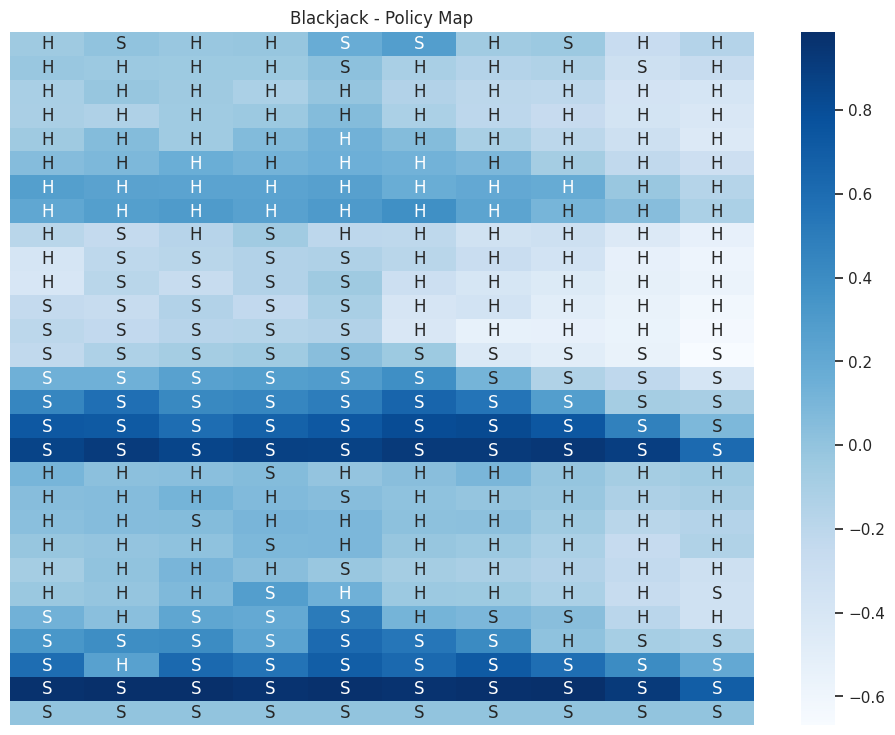

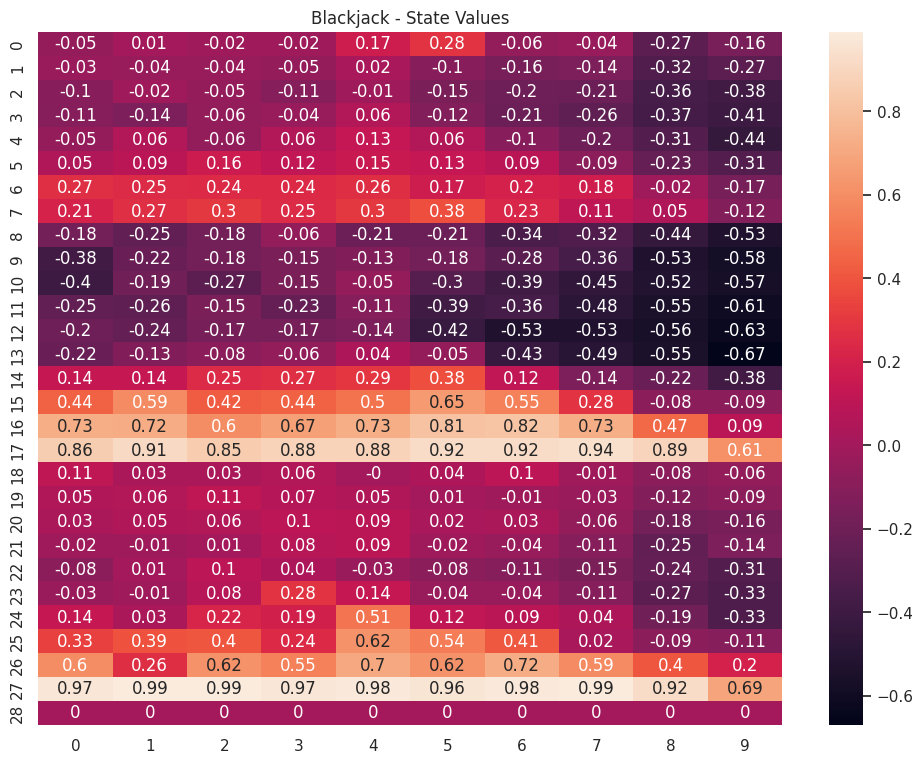

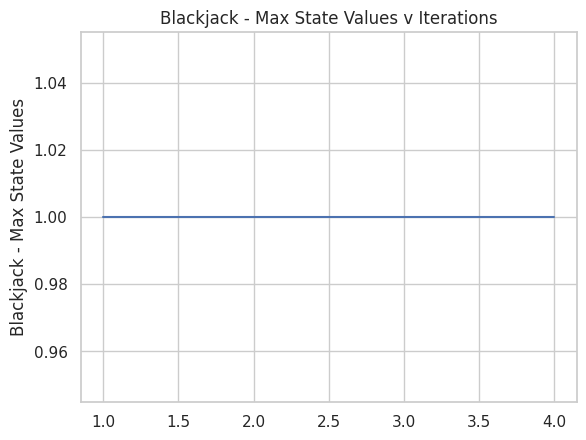

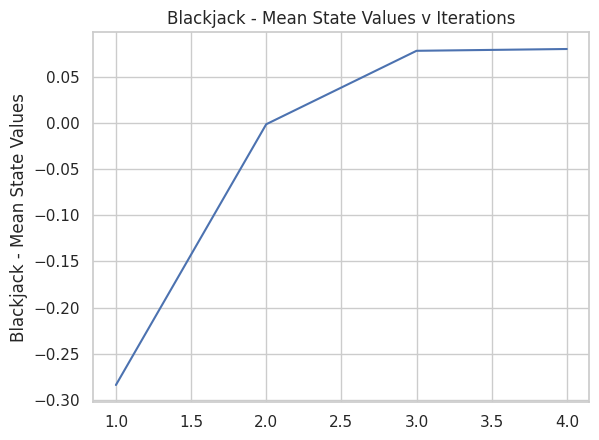

In [283]:
blackjack = Blackjack()
Q, V, pi, Q_track, pi_track = RL(blackjack.env).q_learning(blackjack.n_states, blackjack.n_actions, blackjack.convert_state_obs, epsilon_decay_ratio=0.9, init_epsilon=1, alpha_decay_ratio=0.1, gamma=1, n_episodes= 100000)

n_states = blackjack.n_states

new_pi = list(map(lambda x: pi(x), range(n_states)))

plot_bj_map(np.array(V), np.array(new_pi), "Blackjack - Policy Map")


bj_heat_map(V, "Blackjack - State Values")


max_value_per_iter = np.amax(V_track, axis=1)
max_value_per_iter[max_value_per_iter == 0.0] = np.nan
bj_v_iters_plot(max_value_per_iter, "Blackjack - Max State Values")
mean_value_per_iter = np.mean(V_track, axis=1)
mean_value_per_iter[mean_value_per_iter == 0.0] = np.nan
bj_v_iters_plot(mean_value_per_iter, "Blackjack - Mean State Values")

In [ ]:
# n_states = frozen_lake.observation_space.n
# new_pi = list(map(lambda x: pi(x), range(n_states)))
# s = int(math.sqrt(n_states))

# Plots_Custom.grid_world_policy_plot(np.array(new_pi), "Grid World Policy", size)
# Plots_Custom.grid_values_heat_map(V, "State Values", size)

# mean_q_value_per_iter = np.mean(np.mean(Q_track, axis=2), axis=1)
# Plots_Custom.v_iters_plot(mean_q_value_per_iter, "Mean Q-Values")

# cumulative_rewards_per_iter = np.sum(np.sum(Q_track, axis=2), axis=1)
# Plots_Custom.v_iters_plot(cumulative_rewards_per_iter, "Cumulative rewards")